In [1]:
import tensorflow as tf
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

mnist = tf.keras.datasets.mnist
(X, Y), (X_mnist_test, Y_mnist_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


###1) Utilice los datos de entrenamiento para definir los autovectores de PCA y utilice los datos de testeo para variar la cantidad de componentes principales con las que se quedan para graficar el error cuadrático medio en función de la cantidad de componentes principales. Repita el mismo procedimiento para el porcentaje de energía.

Normalización

In [2]:
medias = np.mean(X,axis=0)
X0 = X - medias

Reshape

In [4]:
X0 = X0.reshape(X0.shape[0], 28 * 28)
X0 = X0.astype('float32')
n,dx=np.shape(X0)


ECM


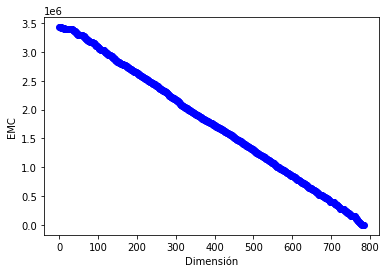

In [5]:
from sklearn import decomposition

# Entro PCA con la máxima componente
pca = decomposition.PCA(n_components = dx)
pca.fit(X0)
U = pca.transform(X0)

dims = list(np.arange(1, dx + 1))
ecm = []

ave = pca.components_
ava = pca.explained_variance_

for dim in range(1,dx + 1):
  U = X0 @ ave[:,:dim]
  Xh = U @ ave[:,:dim].T
  ECM = np.sum((X0-Xh)**2)/n
  ecm.append(ECM)

plt.scatter(dims, ecm, c= "blue")
plt.xlabel("Dimensión")
plt.ylabel("EMC")
plt.show()

Porcentaje de energía

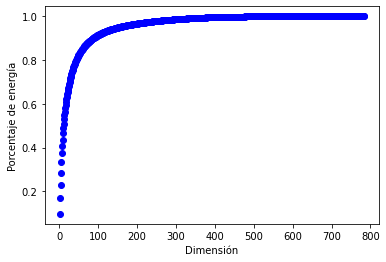

In [6]:
energia_autovalores = []
autovalores = []
for autovalor in ava:
  autovalores.append(autovalor)
  energia_autovalores.append(sum(autovalores) / sum(ava))

plt.scatter(dims, energia_autovalores, c= "blue")
plt.xlabel("Dimensión")
plt.ylabel("Porcentaje de energía")
plt.show()

### 2) Utilice los datos de entrenamiento para definir los autovectores de PCA y haga la reconstrucción sobre los datos de testeo. A ojo estime cuantas componentes principales se necesitan como mínimo para distinguir los dígitos

In [7]:
pca = decomposition.PCA(n_components=40)
pca.fit(X0)
U = pca.transform(X0) 
Xh = pca.inverse_transform(U)
ave = pca.components_
ava = pca.explained_variance_

# Reshape para volver a la dimensión original (3)

Xh = Xh.reshape(Xh.shape[0], 28, 28)

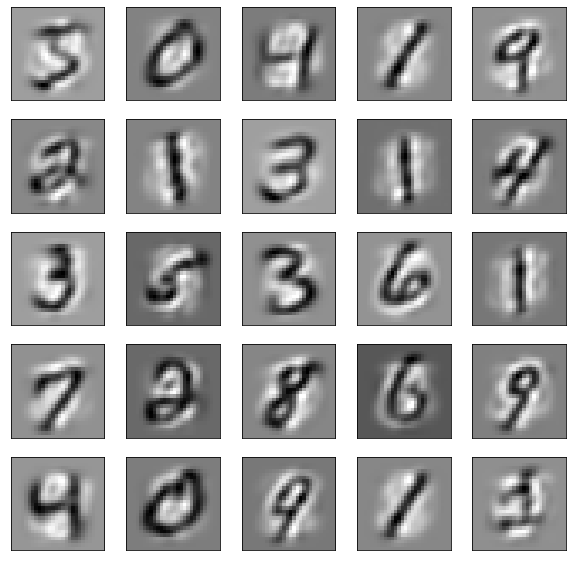

In [8]:
# Grafico

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  #img_index = np.random.randint(0, Xh.shape[0])
  plt.imshow(Xh[i], cmap="gray_r")

Con aproximadamente 40 componentes principales se puede lograr distinguir minimamente los dígitos

### 3) Manifold Learning: La idea es explorar el manifold encontrado por un PCA con 2 componentes principales. Utilice los datos de entrenamiento para entrenar el módulo de PCA, transforme los mismos datos al espacio latente de dimensión dos y anote los valores mínimos y máximos de cada componente. Ahora defina una grilla regular de 10 × 10 entre los valores mínimos y máximos obtenidos. Cada punto de esa grilla (100 en total) debe ser reconstruido en una imagen y mostrar los 100 dígitos reconstruidos en una grilla de 10 × 10 representativa del espacio latente. No sea muy optimista al respecto.

In [9]:
pca = decomposition.PCA(n_components=2)
pca.fit(X0)
U = pca.transform(X0) 
Xh = pca.inverse_transform(U)
ave = pca.components_
ava = pca.explained_variance_

min_prim = min(U[0])
min_seg = min(U[1])
max_prim = max(U[0])
max_seg = max(U[1])

print("El minimo de la primer componente es: ", min_prim)
print("El minimo de la segunda componente es: ", min_seg)
print("El máximo de la primer componente es: ", max_prim)
print("El máximo de la segunda componente es: ", max_seg)

El minimo de la primer componente es:  -312.6648
El minimo de la segunda componente es:  -294.86072
El máximo de la primer componente es:  123.93317
El máximo de la segunda componente es:  1011.719


Completar Grilla meshgrid y linespace

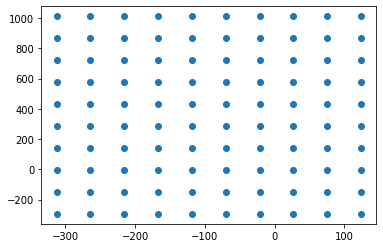

In [17]:
puntos_primer_comp = np.linspace(min_prim, max_prim, 10)
puntos_segunda_comp = np.linspace(min_seg, max_seg, 10)
xx, yy = np.meshgrid(puntos_primer_comp, puntos_segunda_comp)

fig = plt.figure()
plt.scatter(xx,yy)
plt.show()

###4) Detección de anomalías: Utilice los datos de entrenamiento para entrenar el módulo de PCA con la cantidad de componentes principales encontrada en el item 2. Arme una nueva base de datos combinando el conjunto de testeo de MNIST con el conjunto de testeo de FASHION-MNIST (estas van a hacer las veces de imágenes anómalas). Construya un detector de anomalías comparando el error cuadrático de la reconstrucción contra un umbral a denir. En lugar de elegir un umbral, graque la curva ROC y calcule el equal error rate (el error para el umbral que hace iguales a los dos tipos de errores). Va a tener que efectuar una búsqueda bibliográca para entender las curvas ROC (haga su propia implementación!). Repita para 1 componente principal y para 10 y graque las 3 ROC superpuestas. Extraiga conclusiones.

Armo la nueva base de datos combinando el conjunto de testeo de MNIST con el conjunto de FHASHION-MNIST

In [48]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (validation_images, validation_labels) = fashion_mnist.load_data()

# Normalizacion y reshape
media = np.mean(train_images,axis=0)
desvio = np.std(train_images,axis=0)
train_images = (train_images - media)/desvio
ntr = train_images.shape[0] 
dx = train_images.shape[1]*train_images.shape[2] 
validation_images = (validation_images - media)/desvio

mnist = tf.keras.datasets.mnist
(X_mnist_train, Y_mnist_train), (mnist_validation_images, mnist_validation_labels) = mnist.load_data()

# Normalizo MNIST usando la media y el desvio anterior
mnist_validation_images = (mnist_validation_images - media)/desvio

W = np.concatenate((mnist_validation_images, validation_images))
Z = np.concatenate((mnist_validation_labels, validation_labels))

W = W.reshape(W.shape[0], 28 * 28)

Aplico PCA con 40 componentes principales

In [41]:
pca = decomposition.PCA(n_components=40)
pca.fit(W)
U = pca.transform(W) 
Xh = pca.inverse_transform(U)

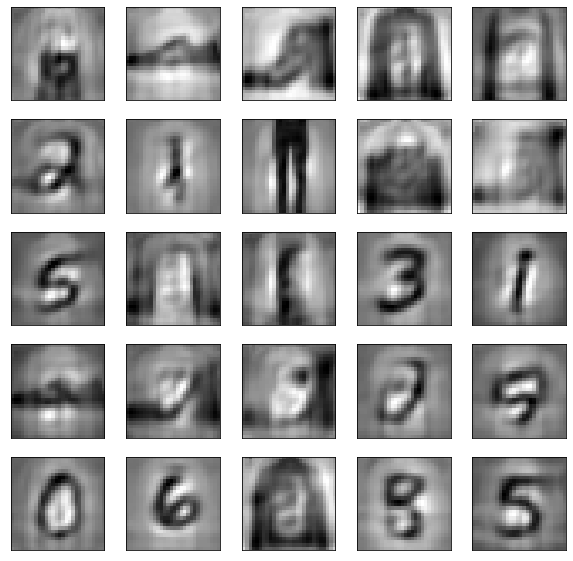

In [44]:
Xh = Xh.reshape(Xh.shape[0], 28, 28)

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(Xh[np.random.randint(0, Xh.shape[0])], cmap="gray_r")

No llegué a hacer la curva ROC. Está implementada más adelante en la tarea de Regularización